In [1]:
import jax.numpy as jnp
import jax
import matplotlib.pyplot as plt
import os

Lets load some images.

In [2]:
def load_sequence(path, grid_size=128):
    # get all files in path
    files = os.listdir(path)
    # sort files
    files.sort()
    print(files)
    # read binary files
    data = []
    for file in files:
        with open(os.path.join(path, file), 'rb') as f:
            grid = jnp.frombuffer(f.read(), dtype=jnp.float32)
            grid = grid.reshape(grid_size, grid_size, grid_size)
            data.append(grid)

    data = jnp.array(data)
    
    return data

density_sequence = load_sequence('data/grid/001')


print(density_sequence.shape)

[]
(0,)


In [8]:
def overdensity(density):
    mean = density.mean()
    return (density - mean) / mean

def resize_sequence(density_sequence, size):
    resize_func = lambda x: jax.image.resize(x, (size, size, size), method='linear')
    density_sequence = jax.vmap(resize_func)(density_sequence)
    return density_sequence

overdensity_sequence = jax.vmap(overdensity)(density_sequence)
resized_overdensity_sequence = resize_sequence(density_sequence, 32)

print(overdensity_sequence.shape)


(11, 128, 128, 128)


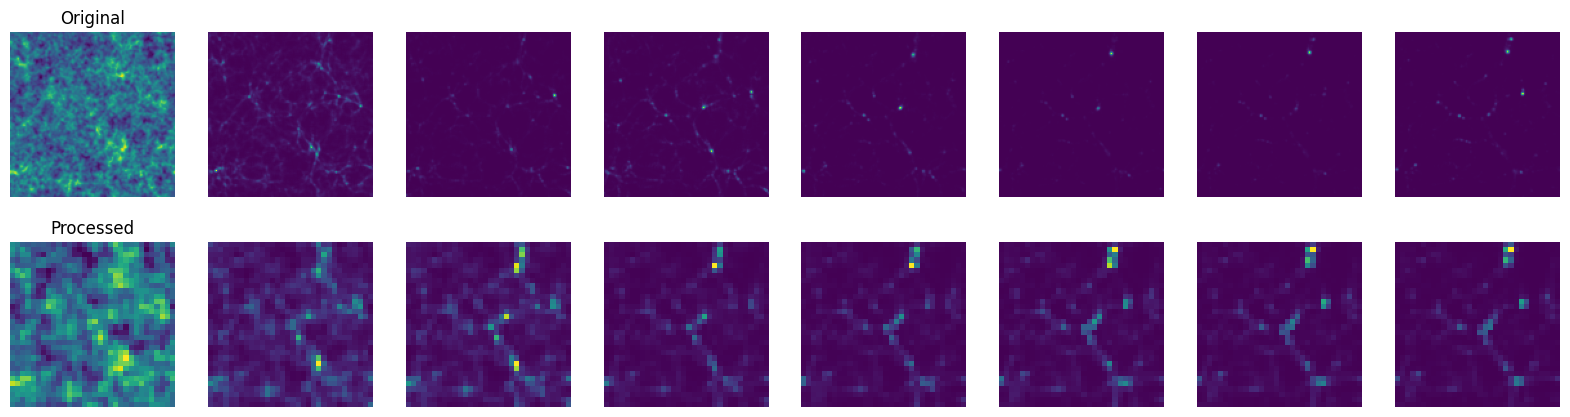

In [9]:
# plot a few slices
fig, ax = plt.subplots(2, 8, figsize=(20, 5))
# plot with normalized colormap
for i in range(8):
    ax[0, i].imshow(density_sequence[i, :, :, density_sequence.shape[-1] //2], cmap='viridis')
    ax[1, i].imshow(resized_overdensity_sequence[i, :, :, resized_overdensity_sequence.shape[-1]//2], cmap='viridis')
    ax[0, i].axis('off')
    ax[1, i].axis('off')
    # set titles
    if i == 0:
        ax[0, i].set_title('Original')
        ax[1, i].set_title('Processed')

In [10]:
# min max mean and std
print('Stats')

print('Min:', jnp.min(overdensity_sequence))
print('Max:', jnp.max(overdensity_sequence))
print('Mean:', jnp.mean(overdensity_sequence))
print('Std:', jnp.std(overdensity_sequence))


Stats
Min: -1.0
Max: 6718.8013
Mean: -2.0169061e-06
Std: 9.714716


In [14]:
import optax
import equinox as eqx
from typing import Callable
import jax.tree_util as jtu

TypeError: 'type' object is not subscriptable

In [139]:
class DoubleConv(eqx.Module):
    conv_1: eqx.nn.Conv
    conv_2: eqx.nn.Conv
    activation : Callable

    def __init__(
        self, 
        num_spatial_dims: int,
        in_channels: int,
        out_channels: int,
        activation: Callable,
        padding: str,
        key
    ):
        key1, key2 = jax.random.split(key)
        self.conv_1 = eqx.nn.Conv(num_spatial_dims, in_channels, out_channels, kernel_size=3, padding=padding, key=key1)
        self.conv_2 = eqx.nn.Conv(num_spatial_dims, out_channels, out_channels, kernel_size=3, padding=padding, key=key2)
        self.activation = activation
        
    def __call__(self, x):
        x = self.conv_1(x)
        x = self.activation(x)
        x = self.conv_2(x)
        x = self.activation(x)
        return x


In [140]:
class UNet(eqx.Module):
    lifting : DoubleConv
    down_sampling : list[eqx.nn.Conv]
    left_arc : list[eqx.nn.Conv]
    right_arc : list[eqx.nn.Conv]
    up_sampling : list[eqx.nn.Conv]
    projection : eqx.nn.Conv

    def __init__(
        self,
        num_spatial_dims: int,
        in_channels: int,
        out_channels: int,
        hidden_channels: int,
        num_levels: int,
        activation: Callable,
        padding: str,
        key):

        key, key_liftiing, key_projection = jax.random.split(key, 3)

        self.lifting = DoubleConv(
            num_spatial_dims, 
            in_channels,
            hidden_channels,
            activation,
            padding,
            key_liftiing
        )

        self.projection = eqx.nn.Conv(
            num_spatial_dims,
            hidden_channels,
            out_channels,
            kernel_size=1,
            padding=padding,
            key=key_projection
        )

        channels_per_level = [hidden_channels * 2**i for i in range(num_levels + 1)]

        self.down_sampling = []
        self.left_arc = []
        self.right_arc = []
        self.up_sampling = []

        for (upper_level_channels, lower_level_channels) in zip(
            channels_per_level[:-1], channels_per_level[1:]):
            key, key_down, key_left, key_right, key_up = jax.random.split(key, 5)

            self.down_sampling.append(
                eqx.nn.Conv(
                    num_spatial_dims,
                    upper_level_channels,
                    upper_level_channels,
                    kernel_size=3,
                    stride=2,
                    padding=padding,
                    key=key_down
                )
            )

            self.left_arc.append(
                DoubleConv(
                    num_spatial_dims,
                    upper_level_channels,
                    lower_level_channels,
                    activation,
                    padding,
                    key_left
                )
            )

            self.right_arc.append(
                DoubleConv(
                    num_spatial_dims,
                    lower_level_channels,
                    upper_level_channels,
                    activation,
                    padding,
                    key_right
                )
            )

            self.up_sampling.append(
                eqx.nn.ConvTranspose(
                    num_spatial_dims,
                    lower_level_channels,
                    upper_level_channels,
                    kernel_size=3,
                    stride=2,
                    padding=padding,
                    key=key_up
                )
            )

    def __call__(self, x):
        print(x.shape)
        x = self.lifting(x)
        residuals = []

        for down, left in zip(self.down_sampling, self.left_arc):
            residuals.append(x)
            x = down(x)
            x = left(x)

        for right, up in zip(reversed(self.right_arc), reversed(self.up_sampling)):
            x = up(x)
            x = jnp.concatenate([x, residuals.pop()], axis=0)
            x = right(x)

        x = self.projection(x)
        
        return x

In [141]:
def count_parameters(model: eqx.Module):
    return sum(p.size for p in jtu.tree_leaves(eqx.filter(model, eqx.is_array)))

In [156]:
from flax import struct

@struct.dataclass
class Batch:
    start : jax.Array
    target : jax.Array

batches = [Batch(grid_sequence_res[1:-1], grid_sequence_res[1:-1] - grid_sequence_res[0:-2])]

In [157]:
init_rng = jax.random.key(0)

unet = UNet(
    num_spatial_dims=3,
    in_channels=1,
    out_channels=1,
    hidden_channels=8,
    num_levels=3,
    activation=jax.nn.relu,
    padding='SAME',	
    key=init_rng
)
parameter_count = count_parameters(unet)
print(f'Number of parameters: {parameter_count}')

# test with random input
input_shape = (1, 32, 32, 32)
input_data = jax.random.normal(init_rng, input_shape)
output_data = unet(input_data)

assert output_data.shape == input_shape

learning_rate = 3e-3

optimizer = optax.adam(learning_rate)
optimzier_state = optimizer.init(eqx.filter(unet, eqx.is_array))

def loss_fn(model : eqx.Module, x : jax.Array, y : jax.Array):
  y_pred = jax.vmap(model)(x)
  mse = jnp.mean(jnp.square(y_pred - y))
  return mse

@eqx.filter_jit
def update_fn(
  model : eqx.Module, 
  optimizer_state : optax.OptState, 
  x : jax.Array, 
  y : jax.Array):

  loss, grad = eqx.filter_value_and_grad(loss_fn)(model, x, y)
  updates, new_optimizer_state = optimizer.update(grad, optimizer_state)
  new_model = eqx.apply_updates(model, updates)
  return new_model, new_optimizer_state, loss

Number of parameters: 437873
(1, 32, 32, 32)


(1, 32, 32, 32)
Epoch 0, Loss: 0.02289775386452675
Epoch 50, Loss: 0.018439635634422302
Epoch 100, Loss: 0.017803043127059937
Epoch 150, Loss: 0.015985772013664246
Epoch 200, Loss: 0.01277413871139288
Epoch 250, Loss: 0.011233950033783913
Epoch 300, Loss: 0.010654471814632416
Epoch 350, Loss: 0.009792761877179146
Epoch 400, Loss: 0.00927222240716219
Epoch 450, Loss: 0.008766457438468933
Epoch 500, Loss: 0.00855353195220232
Epoch 550, Loss: 0.008235123939812183
Epoch 600, Loss: 0.0079362653195858
Epoch 650, Loss: 0.007643039803951979
Epoch 700, Loss: 0.007419817615300417
Epoch 750, Loss: 0.007465175352990627
Epoch 800, Loss: 0.007113958243280649
Epoch 850, Loss: 0.007066323421895504
Epoch 900, Loss: 0.0067329914309084415
Epoch 950, Loss: 0.0066138701513409615


Text(0, 0.5, 'Loss')

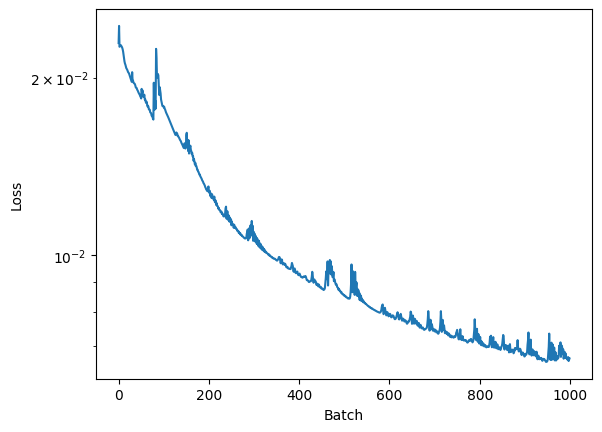

In [158]:
num_epochs = 1000

loss_hist = []
for epoch in range(num_epochs):

  for i in range(len(batches)):
    unet, optimzier_state, loss = update_fn(unet, optimzier_state, batches[i].start, batches[i].target)
  loss_hist.append(loss)
  if epoch % 50 == 0: print(f"Epoch {epoch}, Loss: {loss}")

# log scale plot
plt.plot(loss_hist)
plt.yscale('log')
plt.xlabel('Batch')
plt.ylabel('Loss')

(1, 32, 32, 32)
truth mean: -0.06105485558509827, pred mean: -0.0626613050699234
truth std: 0.15065284073352814, pred std: 0.12745819985866547
truth min: -1.4645733833312988, pred min: -0.901666522026062
truth max: 1.6560778617858887, pred max: 1.1248250007629395


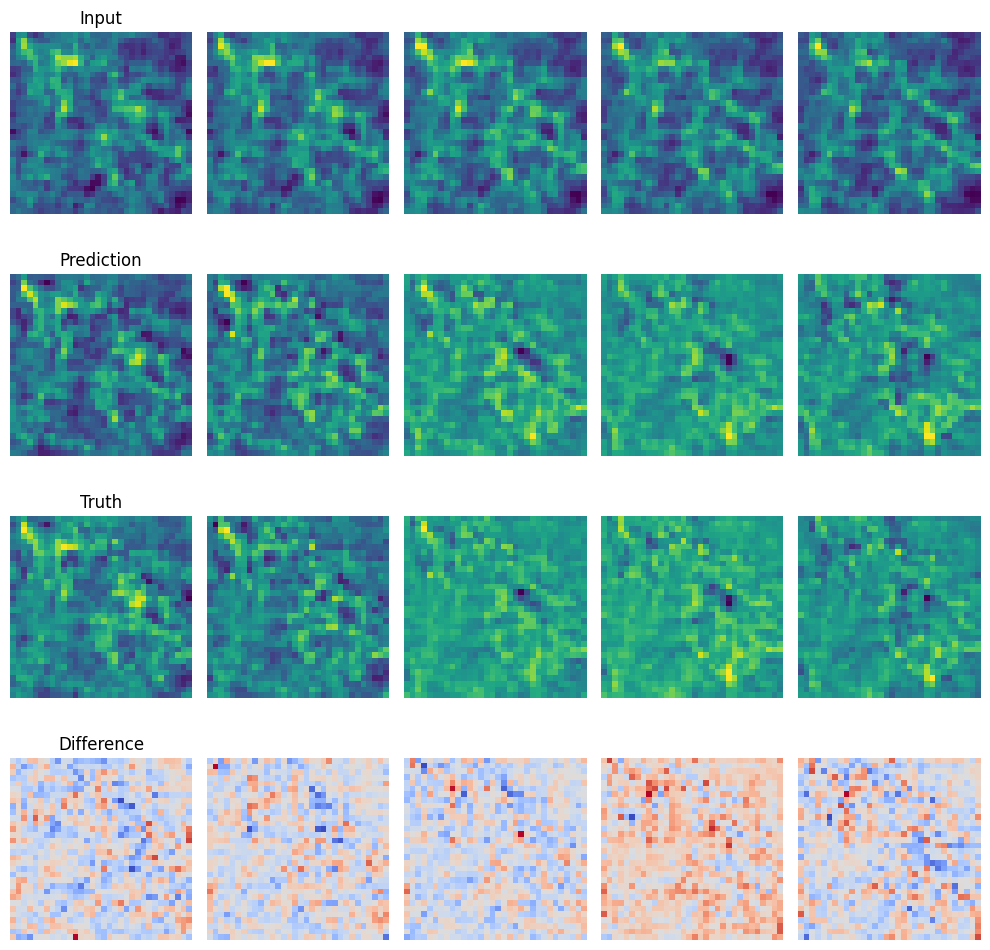

In [159]:
# plot a few predictions
fig, axs = plt.subplots(4, 5, figsize=(10, 10))
x = batches[0].start
y = batches[0].target
y_pred = jax.vmap(unet)(batches[0].start)
print(f"truth mean: {jnp.mean(y)}, pred mean: {jnp.mean(y_pred)}")
print(f"truth std: {jnp.std(y)}, pred std: {jnp.std(y_pred)}")
print(f"truth min: {jnp.min(y)}, pred min: {jnp.min(y_pred)}")
print(f"truth max: {jnp.max(y)}, pred max: {jnp.max(y_pred)}")
for i in range(5):
    axs[0, i].imshow(x[i, 0, :, :, x.shape[-1]//2], cmap='viridis')
    axs[0, i].axis("off")
    axs[1, i].imshow(y_pred[i, 0, :, :, y_pred.shape[-1]//2], cmap='viridis')
    axs[1, i].axis("off")
    axs[2, i].imshow(y[i, 0, :, :, y.shape[-1]//2], cmap='viridis')
    axs[2, i].axis("off")
    axs[3, i].imshow(y_pred[i, 0, :, :, y_pred.shape[-1]//2] - y[i, 0, :, :, y.shape[-1]//2], cmap='coolwarm')
    axs[3, i].axis("off")
    # set titles
    if i == 0:
        axs[1, i].set_title('Prediction')
        axs[2, i].set_title('Truth')
        axs[3, i].set_title('Difference')
        axs[0, i].set_title('Input')

    # colorbar legends

# layout
plt.tight_layout()

# plt.colorbar(axs[2, 0].imshow(y_pred[i, 0, :, :, y_pred.shape[-1]//2] - y[i, 0, :, :, y.shape[-1]//2], cmap='coolwarm'), ax=axs[2, :], orientation='horizontal')



plt.show()

(1, 32, 32, 32)
(1, 32, 32, 32)
(1, 32, 32, 32)
(1, 32, 32, 32)
(1, 32, 32, 32)
(1, 32, 32, 32)
(1, 32, 32, 32)
(1, 32, 32, 32)
(1, 32, 32, 32)
(1, 32, 32, 32)


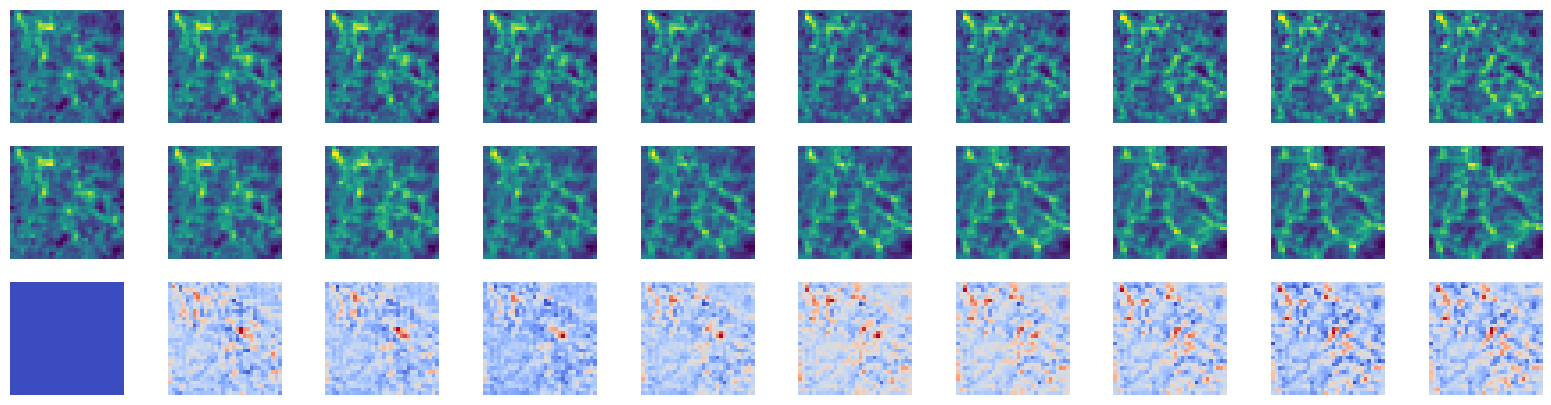

In [170]:
# lets try to predict ahead a few iterations
x = batches[0].start[0]
y = batches[0].start
x_preds = [x]   
for i in range(10):
    x += unet(x)
    x_preds.append(x)

fig, axs = plt.subplots(3, 10, figsize=(20, 5))

for i in range(10):
    axs[0, i].imshow(x_preds[i][0, :, :, x.shape[-1]//2], cmap='viridis')
    axs[0, i].axis("off")
    axs[1, i].imshow(y[i, 0, :, :, y.shape[-1]//2], cmap='viridis')
    axs[1, i].axis("off")
    axs[2, i].imshow(x_preds[i][0, :, :, x.shape[-1]//2] - y[i, 0, :, :, y.shape[-1]//2], cmap='coolwarm')
    axs[2, i].axis("off")